In [1]:
from utils import *
import utils

C:\Users\domin\Anaconda3\envs\tf2\lib\site-packages\tqdm\autonotebook\__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
GAME = 'CartPole-v1'
env = gym.make(GAME)
S, A = env.observation_space.shape[0], env.action_space.n
print(env.observation_space)
print(env.action_space)
print(env.reward_range)

Box(4,)
Discrete(2)
(-inf, inf)


In [3]:
class Model(tf.keras.Model):
    def __init__(self, S, A):
        super().__init__()
        self.W1 = tf.keras.layers.Dense(50, 'relu')
        self.RNN = tf.keras.layers.GRU( 20, recurrent_activation='sigmoid',
                                        return_sequences=False, stateful=False )
        self.W2 = tf.keras.layers.Dense(A)
        self.call(tf.random.uniform([1,3,S]))
        self.call(tf.random.uniform([64,3,S]))
    
    def call(self, x): # [b,s,S]
        x = self.W1(x) # [b,s,50]
        x = self.RNN(x) # [b,20]
        return self.W2(x)
    
create_nn = lambda S,A: Model(S,A)

In [4]:
class Agent():
    def __init__(self, num_states, num_actions, lr, gamma=0.99):
        self.S, self.A = num_states, num_actions
        self.optimizer = tf.optimizers.Adam(lr)
        self.y = gamma
        self.Qnn = create_nn(self.S, self.A) # Q online network
        self.Tnn = create_nn(self.S, self.A) # Target network
        self.Tnn.set_weights( self.Qnn.get_weights() )
        self.seq_len = 3
        self.rnn_seq = deque(maxlen=self.seq_len)
        self.batch_size = 64 # batch size
        self.swap_iters = 100 # if iter > this: swap/copy networks
        self._step = 1 # step count to construct epsilon and swap networks
        self.step2epsilon = create_epsilon_fn([(1.0, 0, 10000)], min_e=0.05) # from 1 to 0 in 10k steps
        self.step2epsilon = lambda x: 0.1
        self.D = deque(maxlen=2000) # experience replay buffer
    
    def first_step(self, s, sdict): # [S]
        a = np.random.randint(self.A) # [] (random move)
        self.s, self.a = s, a # save prev state + action + q value
        # init plot values if not inited
        for a in range(self.A):
            sdict[f'action{a}'] += 0
            sdict[f'Qaction{a}'] += 0
        sdict['epsilon'] += 0
        sdict['loss'] += 0
        return a
        
    def step(self, r, s, sdict): # [], [S]
        # append tuple to experience replay
        self.D.append([self.s, self.a, r, s, False]) # s, a, r, s', done(bool)
        if len(self.D) < self.batch_size: loss = 0
        else: loss = self.update_weights(self.batch_size, sdict)
        sdict['loss'] += float(loss)
        # copy Q network to T network
        if self._step % self.swap_iters == 0:
            self.Tnn.set_weights( self.Qnn.get_weights() )
        # update other vars
        epsilon = self.step2epsilon(self._step)
        sdict['epsilon'] += epsilon
        self._step += 1
        # select action from Q network
        self.rnn_seq.append(s)
        if len(self.rnn_seq) == self.seq_len:
            S = np.array(self.rnn_seq)[None,:] # [1,s,S]
            Q = self.Qnn(S) # [1,A] (last rnn output)
            for a_ in range(self.A): sdict[f'Qaction{a_}'] += float(Q[0,a_])
            a = epsilon_greedy(Q, epsilon) # []
        else:
            a = np.random.randint(self.A) # []
        sdict[f'action{a}'] += 1
        # remember last state + action
        self.s, self.a = s, a
        return a
    
    def update_weights(self, b, sdict): # batch size
        # select batch from experience replay
        S,A,R,Sn,Done = sample_sequences(self.D, b, self.seq_len, shapes=[(self.S,),(),(),(self.S,),()])
        A,R,Done = [i[:,-1] for i in [A,R,Done]]
        Done, A = Done.astype(bool), A.astype(int) # [b,s], [b,s]
        Q = self.Tnn(Sn) # [b,A]
        Qa_hat = R + ~Done * self.y * np.max(Q, axis=-1) # [b]
        # train nn for 1 epoch
        with tf.GradientTape() as tape:
            Q = self.Qnn(S) # [b,A]
            Qa = pick_action_values(values=Q, actions=A) # [b]
            each_loss = tf.reduce_sum( (Qa-Qa_hat)**2 , axis=-1 ) # [b]
            loss = tf.reduce_mean(each_loss) # avg of all examples
        # calc + update gradients
        nn_vars = self.Qnn.trainable_variables
        grads = tape.gradient(loss, nn_vars)
        self.optimizer.apply_gradients(zip(grads, nn_vars))
        return loss
    
    def last_step(self, r, sdict):
        self.D.append([self.s, self.a, r, self.s, True]) # s, a, r, s', done

In [5]:
agent_fn = lambda S,A,env_fn=None: Agent(num_states=S, num_actions=A, lr=1e-3, gamma=0.99)

In [8]:
test_agent_on_simple_games(agent_fn, 'DQN-LSTM', game_dict={'CartPole-v1':500})

True

In [9]:
d = pd.DataFrame()
agent = agent_fn(S,A)
exp = Experiment(env, agent)

In [10]:
df = exp.run(200, 1, name='')
d = d.append(df)

C:\Users\domin\Anaconda3\envs\tf2\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
C:\Users\domin\Anaconda3\envs\tf2\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
C:\Users\domin\Anaconda3\envs\tf2\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior a

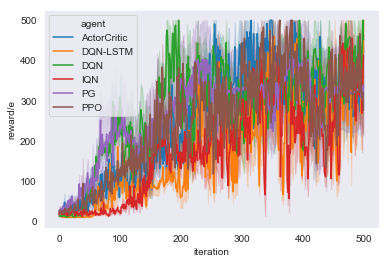

In [12]:
df = load_my_benchmark('CartPole-v1')

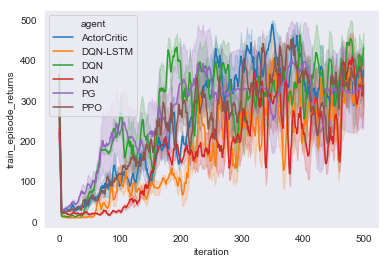

In [14]:
plot_df(df, rolling_mean=5)

In [ ]:
d = d.append(pd.DataFrame(exp.D))

In [ ]:
exp.show_play(10000)

In [ ]:
df = exp.run(100, 1, name='')
d = d.append(df)

In [ ]:
d = pd.DataFrame(exp.D)

In [ ]:
ax = plot_df(df, y=['Qaction0/s', 'Qaction1/s', 'reward/e'], confidence=68)

In [ ]:
# df = exp.run(1000, 1, name='')
# d = d.append(df)

C:\Users\domin\Anaconda3\envs\tf2\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


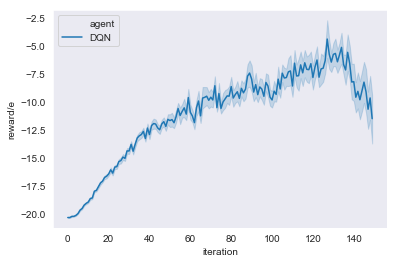

In [15]:
df = load_my_benchmark('Pong-ram-v4')
plot_df(df, y='reward/e')
# df['epsilon/s']

In [ ]:
df = load_atari_benchmark('Pong')
df = df.loc[ df['iteration'] < 15 ]
plot_df(df)